# Predicting faulty water pumps

# Data Cleaning & Feature Engineering & Pre-processing¶

## Import Libraries
Import libraries necessary to get the exploratory data analysis (EDA) part of the project set-up

In [385]:
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from IPython.display import display # use of display() for DataFrames
from mpl_toolkits.basemap import Basemap

# Import Preprocessing and ML libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

%matplotlib inline

In [386]:
# Utility Function to compute the correlation of categorical features

# Source: https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

# Search for categorical variables that are highly correlated
def show_cat_correlation(df, cat_feature_list, threshold=0.80):
    print("show_cat_correlation: categorical feature list {}".format(cat_feature_list))
    for i, col_i in enumerate(cat_feature_list):
        for j, col_j in enumerate(cat_feature_list):
            if (i < j):
                cross_tab = pd.crosstab(df[col_i], df[col_j]).values # contingency table
                cramer_corr = cramers_corrected_stat(cross_tab) # Cramer V statistic
                if (cramer_corr > threshold):
                    print("Cramer's correlation for {} and {} is {}".format(col_i, col_j, int(cramer_corr*100)))

In [387]:
class GIS_Map_Viz:
    
    def __init__(self,  latitude_feature_name, longitude_feature_name, gps_bounderies_dict):
        '''create a GIS gps map '''
        # Save data features by type and label
        print("GIS_Map_Viz: __init__ ...")
        self.latitude_feature_name = latitude_feature_name
        self.longitude_feature_name = longitude_feature_name
        self.gps_bounderies_dict = gps_bounderies_dict
        
    def _display_gps_map(self, df, map_title):
        '''print the longitude & latitude GPS coordinates of the dataframe within the map bounderies'''
        print("GIS_Map_Viz: _display_gps_map ...")
        fig = plt.figure(figsize =(20,10))
        fig.suptitle(map_title)
        
        m = Basemap(
            projection='merc', 
            llcrnrlat=self.gps_bounderies_dict['lat_min']-0.5, 
            urcrnrlat=self.gps_bounderies_dict['lat_max']+0.5, 
            llcrnrlon=self.gps_bounderies_dict['lon_min']-0.5, 
            urcrnrlon=self.gps_bounderies_dict['lon_max']+0.5,
            resolution='i'
        )

        # Reference: https://matplotlib.org/basemap/users/geography.html
        m.drawmapboundary(fill_color='#85A6D9')
        m.drawcoastlines(color='#6D5F47', linewidth=.8)
        m.drawrivers(color='green', linewidth=.4)
        m.shadedrelief()
        m.drawcountries()
        m.fillcontinents(lake_color='aqua')

        longitudes = df[self.longitude_feature_name].tolist()
        latitudes = df[self.latitude_feature_name].tolist()
        m.scatter(longitudes, latitudes, s=0.05, zorder=2, latlon=True,  c='blue', cmap="summer")
        plt.show()

In [388]:
_debug = False

class Water_Asset_Data:
    def __init__(self, train_feature_file, train_label_file, test_feature_file, cat_cols, ord_cols, bool_cols, num_cols, label_col, id_col):
        '''create training and testing panda dataframes'''
        # Save data features by type and label
        print("Water_Asset_Data: __init__ ...")
        
        self.cat_cols = list(cat_cols)
        self.num_cols = list(num_cols)
        self.bool_cols = list(bool_cols)
        self.ord_cols = list(ord_cols)
        self.label_col = label_col
        self.id_col = id_col       
        self.feature_cols = cat_cols + num_cols + bool_cols
        self.label_names = []
        
        self.saved_train_file_name = 'clean_wp_train_features_df_'
        self.saved_test_file_name = 'clean_wp_test_features_df_'
        self.saved_object_file_name = 'clean_wp_data_object_'
        
        # Approximate GPS bounderies of Tanzania (hardcoded)
        self.gps_bounderies_dict = {'lat_min': -12, 'lat_max': 0, 'lon_min': 30, 'lon_max': 40, 'height_min': 0}     
        
        # Save our train and test data frames
        self.train_feature_df = self._create_train_feature_df(train_feature_file, train_label_file)
        self.test_feature_df = self._create_test_feature_df(test_feature_file)
        

    def _create_train_feature_df(self, train_feature_file, train_target_file, clean_features=True, shuffle_data=True):
        '''loads, merges training data features and targets, clean the resulting training dataframe from missing values'''
        print("Water_Asset_Data: _create_train_feature_df ...")
        
        train_feature_df = self._load_data_file(train_feature_file)
        train_target_df = self._load_data_file(train_target_file)
        train_df = self._merge_df(train_feature_df, train_target_df, self.id_col)
        self.label_names = train_df[self.label_col].unique()
        
        if clean_features:
            train_df = self._clean_data(train_df)
        if shuffle_data:
            train_df = self._shuffle_data(train_df)
        return train_df
    
    def _create_test_feature_df(self, test_feature_file, clean_features=True):
        '''loads clean the resulting test dataframe from missing values'''
        print("Water_Asset_Data: _create_test_feature_df ...")
        
        test_df = self._load_data_file(test_feature_file)
        if clean_features:
            self._clean_data(test_df)                        
        return test_df
    
    def _encode_features(self):
        '''Preprocess and encode features'''
        encoded_train_feature_df = self.train_feature_df.drop(self.cat_cols[:-1], axis=1).copy()
        encoded_test_feature_df = self.test_feature_df.drop(self.cat_cols[:-1], axis=1).copy()
        
        # Encode label feature
        print("Water_Asset_Data: _encode_features label {}".format(self.label_col))
        encoded_train_feature_df[self.label_col] = pd.Categorical(self.train_feature_df[self.label_col]).codes
        #encoded_train_feature_df[self.label_col] = self.train_feature_df[self.label_col]
        
        # Encode boolean features
        print("Water_Asset_Data: _encode_features boolean {}".format(self.bool_cols))
        for col in self.bool_cols:
            encoded_train_feature_df[col] = self.train_feature_df[col] * 1
            encoded_test_feature_df[col] = self.test_feature_df[col] * 1
            
        #  numeric features
        print("Water_Asset_Data: _encode_features numeric {}".format(self.num_cols))
        encoded_train_feature_df[self.num_cols] = self.train_feature_df[self.num_cols].apply(pd.to_numeric)
        encoded_test_feature_df[self.num_cols] = self.test_feature_df[self.num_cols].apply(pd.to_numeric)
        
        #  ordinal features
        print("Water_Asset_Data: _encode_features numeric {}".format(self.ord_cols))
        encoded_train_feature_df[self.ord_cols] = self.train_feature_df[self.ord_cols].apply(pd.to_numeric)
        encoded_test_feature_df[self.ord_cols] = self.test_feature_df[self.ord_cols].apply(pd.to_numeric)
        
        # One hot encode all other categorical features
        print("Water_Asset_Data: _encode_features categorical {}".format(self.cat_cols[:-1]))
        encoded_cat_train_feature_df = pd.get_dummies(self.train_feature_df[self.cat_cols[:-1]])
        encoded_cat_test_feature_df = pd.get_dummies(self.test_feature_df[self.cat_cols[:-1]])

        print("Water_Asset_Data: ** DEBUG ** _encode_features train set shape {} , test set shape {}".format( \
               encoded_train_feature_df.shape, encoded_test_feature_df.shape))             
        
        self.train_feature_df = pd.concat([encoded_train_feature_df, encoded_cat_train_feature_df], axis=1)                                       
        self.test_feature_df = pd.concat([encoded_test_feature_df, encoded_cat_test_feature_df], axis=1)                                
        
        print("Water_Asset_Data: _encode_features train set shape {} , test set shape {}".format( \
               self.train_feature_df.shape, self.test_feature_df.shape))        

    def _engineer_features(self):
        '''Generate features for test and training dataframes'''
        print("Water_Asset_Data: _engineer_features ...")
        self.train_feature_df = self._engineer_age_feature(self.train_feature_df)
        self.test_feature_df = self._engineer_age_feature(self.test_feature_df)
    
    def _load_data_file(self, file_name, verbose = True):
        '''Load Pickle data file'''
        file_df = pd.read_pickle(file_name)
        if verbose:
            print("Water_Asset_Data: _load_data_file - pickle file {} loaded with shape {}".format(file_name,file_df.shape))
        return file_df

    def _save_dfs_to_file(self, clean_dir, verbose = False):
        '''Save dataframes to pickle data file'''
        print("Water_Asset_Data: _save_df_to_file to {}".format(clean_dir))
        
        file_time = datetime.datetime.now().strftime ("%y%m%d%H")        
        train_pkl_file = clean_dir +  self.saved_train_file_name + file_time + '.pkl'
        test_pkl_file = clean_dir +  self.saved_test_file_name + file_time + '.pkl'
        # Save cleaned panda dfs in repository
        try:
            self.train_feature_df.to_pickle(train_pkl_file)
            self.test_feature_df.to_pickle(test_pkl_file)
            if verbose:
                print("Water_Asset_Data: _save_df_to_file - {} and {} saved".format(train_pkl_file,test_pkl_file))   
        except:
            print("Water_Asset_Data: _save_df_to_file {} failed".format(train_pkl_file,test_pkl_file))
            
    def _save_object_to_file(self, clean_dir, verbose = False):        
        # Save the wp_data object in the clean-data repository
        print("Water_Asset_Data: _save_object_to_file to {}".format(clean_dir))
        
        file_time = datetime.datetime.now().strftime ("%y%m%d%H")
        object_pkl_file = clean_dir +  self.saved_object_file_name + file_time + '.pkl'
        # Save cleaned Water_Asset_Data object in repository
        with open(object_pkl_file, 'wb') as f:
            pickle.dump(wp_data, f, pickle.HIGHEST_PROTOCOL)
    
    def _merge_df(self, train_feature_df, train_label_df, merge_on_feature):
        '''Merge the training and label df on a specific key'''
        merged_df = pd.merge(left=train_feature_df, right=train_label_df, how='inner', on=merge_on_feature)
        return merged_df
        
    def _shuffle_data(self, df):
        '''Shuffle the observation in the dataframe'''
        return shuffle(df)
    
    def _clean_data(self, df):
        '''Impute missing values'''
        print("Water_Asset_Data: _clean_data ...")
        col_names = df.columns.tolist()
        
        # Transform ordinal values as object values 
        for col in self.ord_cols:
            if col in col_names:
                df[col] = df[col].astype('str')

        # Normalise string categorical features to lower case
        for col in cat_cols:
            if col in col_names:
                df[col] = df[col].str.lower()
        
        # Transform all numerical values into numeric values
        df[self.num_cols] = df[self.num_cols].apply(pd.to_numeric)                
        
        # Remove scheme_name feature (too many missing values)
        self._drop_features(df, ['scheme_name'])
        
        # replace invalid construction_years (0) with the median construction year
        valid_construction_year_df = df[df['construction_year'] > 0] 
        median_construction_year_value=int(valid_construction_year_df['construction_year'].median())
        df['construction_year'].replace(0, median_construction_year_value,inplace=True)
        
        # replace likely invalid GPS values (out of Tanzania bounderies)
        self._clean_GPS_features(df, verbose = _debug)
        
        # replace funder feature missing values with its highest occurence
        self._impute_null_with_highest_frequency_value(df, 'funder', verbose = _debug)    
        # replace installer feature missing values with its highest occurence
        self._impute_null_with_highest_frequency_value(df, 'installer', verbose = _debug)
        # replace public_meeting feature missing values by highest occurence
        self._impute_null_with_highest_frequency_value(df, 'public_meeting', verbose = _debug)
        # replace scheme_management feature missing values by highest occurence for each funder category
        self._impute_null_with_highest_frequency_value(df, 'scheme_management', 'funder', verbose = _debug)
        # replace scheme_management feature missing values with highest occurence for each installer category
        self._impute_null_with_highest_frequency_value(df, 'permit', 'installer', verbose = _debug)        
        # replace subvillage feature missing values with highest occurence for each region category
        self._impute_null_with_highest_frequency_value(df, 'subvillage', 'region', verbose = _debug)
        
        # Check if the training set has any missing values
        num_null_val = df.isnull().sum().sort_values(ascending=False)        
        if _debug:
            display(num_null_val.head())            
        assert (sum(num_null_val) == 0), "Water_Asset_Data: _clean_data - dataframe has missing values"
        
        print("Water_Asset_Data: _clean_data - data frame shape {}".format(df.shape))
        print("Water_Asset_Data: _clean_data - data frame feature list {} \n".format(df.columns.tolist()))
        return(df)

    def _engineer_age_feature(self, df):
        '''Generate new age features'''
        print("Water_Asset_Data: _engineer_age_feature \'pump_age\' ...")
        
        # Extract the of date_recorded feature and create a new feature: year_recorded
        df['year_recorded'] = df['date_recorded'].apply(self._extract_year)
        self.num_cols += ['year_recorded']
        
        # Compute the age of the pumps (in years) based on the construction_year and year of the obervation extracted
        df['pump_age'] = abs(df['year_recorded'] - df['construction_year'])
        self.num_cols += ['pump_age']
        
        return(df)
    
    def _shrink_cat_features(self, cat_feature_list, threshold):
        '''Replace categorical feature values with number of occurence below the treshhold provided '''
        print("_shrink_cat_features: _shrink_cat_features {}".format(cat_feature_list))
        for feature in cat_feature_list:
            self.train_feature_df[feature] = self._shrink_cat_feature(self.train_feature_df, feature, threshold)                                    
            self.test_feature_df[feature] = self._shrink_cat_feature(self.test_feature_df, feature, threshold)                           
    
    def _shrink_cat_feature(self, df, cat_feature, threshold): 
        '''Replace categorical feature values with number of occurence below the treshhold provided '''
        print("Water_Asset_Data: shrink_cat_feature {}".format(cat_feature))
        s = (df[cat_feature].value_counts() <= threshold)
        list_to_replace = list(s[s == True].index)
        shrunk_cat_feature = df[cat_feature].apply(lambda x: (cat_feature + "_rare") if x in list_to_replace else x)
        return(shrunk_cat_feature)
    
    def _drop_features(self, df, feature_list):
        '''Remove feature list from data frames'''
        print("Water_Asset_Data: _drop_features ...")
        df.drop(feature_list, axis =1, inplace = True)        
        for feature in feature_list:
            if feature in self.cat_cols:        
                self.cat_cols.remove(feature)
            if feature in self.num_cols:        
                self.num_cols.remove(feature)
            if feature in self.bool_cols:        
                self.bool_cols.remove(feature)
            if feature in self.ord_cols:        
                self.ord_cols.remove(feature)               
        print("Water_Asset_Data: _drop_features - {} were dropped".format(feature_list))

    def _clean_GPS_features(self, df, verbose = False):
        '''Generate GPS features which seem out of Tanzania bounderies'''    
        correct_gps_df = df[
            (df['latitude'] > self.gps_bounderies_dict['lat_min'] ) & (df['latitude'] < self.gps_bounderies_dict['lat_max']) & \
            (df['longitude'] > self.gps_bounderies_dict['lon_min']  ) & (df['longitude'] < self.gps_bounderies_dict['lon_max']) & \
            (df['gps_height'] > self.gps_bounderies_dict['height_min']) ]

        # mean of gps coordinate types in each Tanzanian basin
        mean_correct_gps_df = correct_gps_df.groupby(['basin'])['latitude','longitude','gps_height'].mean() 

        # Replace likely invalid GPS values for each basin by basin GPS means
        basin_list = df['basin'].unique()
        for i in basin_list:
            correct_lon = mean_correct_gps_df.loc[i, 'longitude']
            if verbose:
                print("Updating invalid longitutes for basin {} by mean {}".format(i,correct_lon))
            df[((df['longitude'] < self.gps_bounderies_dict['lon_min']) | (df['longitude'] > self.gps_bounderies_dict['lon_max'])) & \
                (df['basin'] == i)]['longitude'] = correct_lon

            correct_lat = mean_correct_gps_df.loc[i, 'latitude']
            if verbose:
                print("Updating invalid latitudes for basin {} by mean {}".format(i,correct_lat))
            df[((df['latitude'] < self.gps_bounderies_dict['lat_min'] ) | (df['latitude'] > self.gps_bounderies_dict['lat_max'])) & \
                (df['basin'] == i)]['latitude'] = correct_lat

            correct_height = mean_correct_gps_df.loc[i, 'gps_height']
            if verbose:
                print("Updating invalid heights for basin {} by mean {}".format(i,correct_height))
            df[(df['gps_height'] > self.gps_bounderies_dict['height_min']) & \
               (df['basin'] == i)]['gps_height'] = correct_height
        
        return(df)
        
    def _extract_year(self, date):
        return (int(date.split('-')[0]))
        
    def _remove_list(self, orginal_list, list_to_be_removed):
        '''Remove a sublist from a list'''
        for i in list_to_be_removed:
            orginal_list.remove(i)        

    def _impute_null_with_highest_frequency_value(self, df, impute_feature, frequency_feature = [], verbose = False):
        '''impute missing values based on the hightest occurence of this feature in a seperate data slice'''
        impute_cat_set = df[impute_feature].nunique()
        
        if frequency_feature: 
            feat_cat_list = df[frequency_feature].unique()
            for i in feat_cat_list:
                feat_cat = df[df[frequency_feature] == i][impute_feature]  
                highest_feat_cat_occurence = df[frequency_feature].value_counts().idxmax()
                if sum(feat_cat.notnull()):
                    highest_feat_cat_occurence = feat_cat.value_counts().idxmax()        
                if verbose:
                    print("Replacing {} feature null values: {} imputed by {}".format(impute_feature,i,highest_feat_cat_occurence))
                df[impute_feature].fillna(value=highest_feat_cat_occurence, inplace = True)
        else:
            highest_feat_cat_occurence = df[impute_feature].value_counts().idxmax()
            if verbose:
                print("Replacing {} feature null values by {}".format(impute_feature,highest_feat_cat_occurence))
            df[impute_feature].fillna(value=highest_feat_cat_occurence, inplace = True)
                
        # Sanity check: null values have been replaced 
        assert impute_cat_set == df[impute_feature].nunique(), "Water_Asset_Data: - impute_null_with_highest_frequency_value: null values replaced assert failed"        

In [445]:
class ModelManager:
    def __init__(self, model_dict={}, benchmark_model = "", label_names = "", num_procs = -1):
        '''creates model dictionary and manager object'''
        self.model_dict = model_dict
        self.benchmark_model = benchmark_model
        self.best_model = None
        self.predictions = None
        self.scoring = f1_score #f1_score # 'f1', average=’macro’
        self.test_train_ratio = 0.3 #train and validation set -> 30% , 70%
        self.num_procs = num_procs
        self.label_names = label_names
         
        
    def _add_model(self, new_model_pair):
        '''add a model to the  manager object  '''
        self.model_dict.update(new_model_pair)
        
    def _make_scorer(self):    
        return(make_scorer(self.scoring, average='macro'))
        #return(make_scorer(self.scoring))

    def _cross_validate(self, wp_data_instance, k_fold=10):
        '''train_test_split or k fold cross validate models on the train dataframe in Water_Asset_Data object '''   
        
        target_df = wp_data_instance.train_feature_df[wp_data.label_col]
        feature_df = wp_data_instance.train_feature_df.drop(wp_data.label_col, axis = 1)
        custom_scorer = self._make_scorer()
        # Split the data into a train and a test set
        X_train, X_test, y_train, y_test = train_test_split(feature_df, target_df, test_size=self.test_train_ratio)
        
        for model_name, model in self.model_dict.items():
            if (model_name != benchmark_model):   
                cv_results = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=custom_scorer, n_jobs=self.num_procs)
                print("F1 score for model {}: {:.2f} - {:.3f}".format(model_name, cv_results.mean(), cv_results.std()))

            model.fit(X_train,y_train)
            predictions = model.predict(X_test)
            cm = confusion_matrix(y_test,predictions)
            np.set_printoptions(precision=2)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize confusion matrix
                        
            print("Overall Accuracy for model {} = {:.2f}".format(model_name, accuracy_score(y_test,predictions)))
            print("Normalize Confusion matrix for model {}".format(model_name))
            print(cm)
            
            if hasattr(model, 'feature_importances_'):
                feature_importance = pd.Series(model.feature_importances_, list(X_train)).sort_values(ascending=False).head(10)
                feature_importance.plot(kind='bar', title= (model_name + ': Importance of Features'))

In [390]:
#kfold = model_selection.KFold(n_splits=10, random_state=seed)
#model = LogisticRegression()
#results = model_selection.cross_val_score(model, X, Y, cv=kfold)
#for model in self.models:
#results = StratifiedKFold(model, feature_df, target_df, cv=k, n_jobs=num_procs, scoring='neg_mean_squared_error')
#self.mean_mse[model] = -1.0*np.mean(neg_mse)

## Load Water Pump Data Files, Create Data Frames and Clean The Data

#### Read in the data pump files stored in the directory raw-data into Pandas dataframes

In [391]:
!dir raw-data\*.pkl

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\raw-data

05/31/2018  12:20 PM         3,634,926 pump_test_features_df.pkl
05/31/2018  12:20 PM        14,615,910 pump_train_features_df.pkl
05/31/2018  12:20 PM           594,995 pump_train_label_df.pkl
06/18/2018  08:19 PM        32,059,977 wp_clean_data.pkl
               4 File(s)     50,905,808 bytes
               0 Dir(s)  1,927,629,799,424 bytes free


#### Define our different feature lists on which we will perform cleaning operation

In [392]:
# Define the data files extracted from the EDA phase
raw_data_dir = 'raw-data\\'
clean_data_dir = 'clean-data\\'

train_feature_file = raw_data_dir + 'pump_train_features_df.pkl'
train_label_file = raw_data_dir + 'pump_train_label_df.pkl'
test_feature_file = raw_data_dir + 'pump_test_features_df.pkl'

# Define the feature variables
cat_cols = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 
            'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 
            'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 
            'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 
            'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 
            'waterpoint_type_group', 'status_group']

bool_cols = ['public_meeting', 'permit']

ord_cols = ['region_code', 'district_code']

num_cols = ['gps_height', 'population', 'construction_year', 'amount_tsh', 'longitude', 'latitude']

label_col = 'status_group'

id_col = 'id'

#### Create our cleaned testing and training data sets

### Inpute missing values
We've previously seen that the following features in the training set have NaN values that we will drop or impute: <br/> <br/>

<B> Nan/Null values count by feature: </B>

* scheme_name:              28166
* scheme_management:         3877
* installer:                 3655
* funder:                    3635
* public_meeting:            3334
* permit:                    3056
* subvillage:                 371

<br/> The Water_Asset_Data object will impute missing values and drop the scheme_name feature

In [393]:
# Create the data object to save the data frames
wp_data = Water_Asset_Data(train_feature_file, train_label_file, test_feature_file, \
                           cat_cols, ord_cols, bool_cols, num_cols, label_col, id_col)

Water_Asset_Data: __init__ ...
Water_Asset_Data: _create_train_feature_df ...
Water_Asset_Data: _load_data_file - pickle file raw-data\pump_train_features_df.pkl loaded with shape (59400, 40)
Water_Asset_Data: _load_data_file - pickle file raw-data\pump_train_label_df.pkl loaded with shape (59400, 2)
Water_Asset_Data: _clean_data ...
Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['scheme_name'] were dropped


C:\Users\Chris Cochet\Anaconda3\envs\Udacity_MLND\lib\site-packages\ipykernel_launcher.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Chris Cochet\Anaconda3\envs\Udacity_MLND\lib\site-packages\ipykernel_launcher.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Water_Asset_Data: _clean_data - data frame shape (59400, 40)
Water_Asset_Data: _clean_data - data frame feature list ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group'] 

Water_Asset_Data: _create_test_feature_df ...
Water_Asset_Data: _load_data_file - pickle file raw-data\pump_test_features_df.pkl loaded with shape (14850, 40)
Water_Asset_Data: _clean_data ...
Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['scheme_name']

#### Check that no missing values have been left in both the test and training data set

In [394]:
display(wp_data.train_feature_df.isnull().sum().sort_values(ascending=False).head(5))
wp_data.train_feature_df.shape

status_group             0
waterpoint_type_group    0
population               0
ward                     0
lga                      0
dtype: int64

(59400, 40)

In [395]:
display(wp_data.train_feature_df.isnull().sum().sort_values(ascending=False).head(5))
wp_data.test_feature_df.head()

status_group             0
waterpoint_type_group    0
population               0
ward                     0
lga                      0
dtype: int64

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,dmdd,1996,dmdd,35.290799,-4.059696,dinamu secondary school,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,government of tanzania,1569,dwe,36.656709,-3.309214,kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,government of tanzania,1567,dwe,34.767863,-5.004344,puma secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,finn water,267,finn water,38.058046,-9.418672,kwa mzee pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,bruder,1260,bruder,35.006123,-10.950412,kwa mzee turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


#### Check that GPS information seems correct and print map of water points

We've previously noticed that some of these GPS value are invalid (e.g. negative altitude) as Tanzania has the following GPS bounderies:
* height > 0
* latitude: between 0S and -12S
* longitude: between 30E and 40E </br>

The GPS information that didn't fit into the country bounderies has now been cleaned-up <br/>
Tanzania is divided in water basin areas and this is likely relevant information for the prediction of the pump status.
We've replaced each GPS location that is out of the countries bounderies with the corresponding mean gps value of the basin it belongs to. <br/>

In [396]:
basin_list = wp_data.train_feature_df['basin'].unique()
wp_data.train_feature_df['basin'].value_counts()

lake victoria              10248
pangani                     8940
rufiji                      7976
internal                    7785
lake tanganyika             6432
wami / ruvu                 5987
lake nyasa                  5085
ruvuma / southern coast     4493
lake rukwa                  2454
Name: basin, dtype: int64

Now let's check that the gps features clean-up performed worked out properly

GIS_Map_Viz: __init__ ...
GIS_Map_Viz: _display_gps_map ...


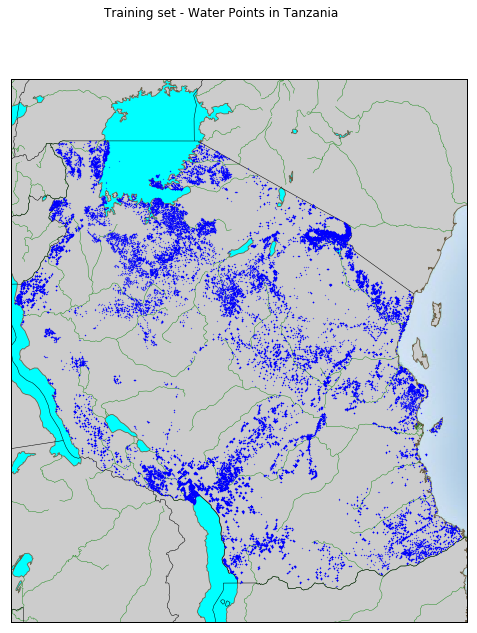

GIS_Map_Viz: _display_gps_map ...


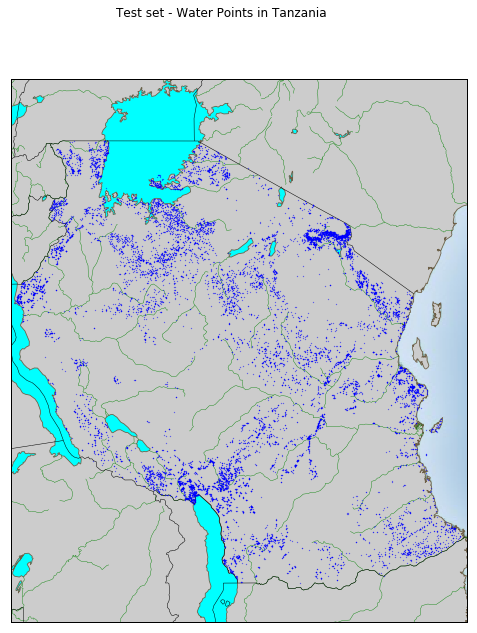

In [397]:
# feature names to be mapped
gps_map_features = ['latitude','longitude']
# create a map object
wp_map = GIS_Map_Viz(gps_map_features[0],gps_map_features[1],wp_data.gps_bounderies_dict)
# Display the map with water points
wp_map._display_gps_map(wp_data.train_feature_df, "Training set - Water Points in Tanzania")
wp_map._display_gps_map(wp_data.test_feature_df, "Test set - Water Points in Tanzania")

We observe that there are dense clusters of water points in the North and South East of the country while other areas are very water asset scarce

## Engineer Features

#### Compute the age of the pumps based on the construction_year
The age of the pump will likely be a better predictor of a pump failure than the year it was constructed. <br/>
We will compute the age of the pumps at the time the data set observations were recorded

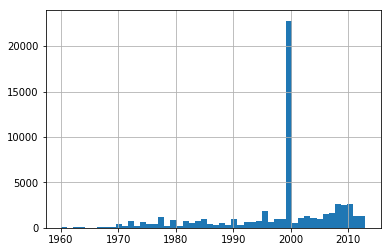

In [398]:
# Inspect construction_year feature
wp_data.train_feature_df['construction_year'].hist(bins = 50)

In [399]:
# Compute the median contruction_year for pumps
wp_data._engineer_features()

Water_Asset_Data: _engineer_features ...
Water_Asset_Data: _engineer_age_feature 'pump_age' ...
Water_Asset_Data: _engineer_age_feature 'pump_age' ...


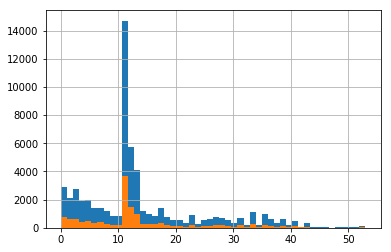

In [400]:
# Inspect construction_year feature
wp_data.train_feature_df['pump_age'].hist(bins = 50)
wp_data.test_feature_df['pump_age'].hist(bins = 50)

## Remove Irrelevant Features 
Some fatures likely have little correlation with the business outcome (pump failure prediction) and labels.<br/> 
In particular, we will drop the following features:
* date_recorded & year_recorded - The date and the year the row was entered
* recorded_by - Group entering this row of data
* num_private - No definitions provided

In [401]:
# drop irrelevant features
irrelevant_feat_list = ['date_recorded', 'num_private', 'id', 'year_recorded', 'recorded_by']
init_train_shape = wp_data.train_feature_df.shape
init_test_shape = wp_data.test_feature_df.shape

wp_data._drop_features(wp_data.train_feature_df, irrelevant_feat_list)
print ("Train set shape: {} to {} ".format(init_train_shape, wp_data.train_feature_df.shape))

wp_data._drop_features(wp_data.test_feature_df, irrelevant_feat_list)
print ("Test set shape: {} to {} ".format(init_test_shape, wp_data.test_feature_df.shape))

Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['date_recorded', 'num_private', 'id', 'year_recorded', 'recorded_by'] were dropped
Train set shape: (59400, 42) to (59400, 37) 
Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['date_recorded', 'num_private', 'id', 'year_recorded', 'recorded_by'] were dropped
Test set shape: (14850, 41) to (14850, 36) 


#### Remove categorical features which are highly correlated or with high cardinalities (too many levels)

We observe that there are many data features with geographic information about the water points and wells, and soem of these have many different levels :
- Tanzania is divided into thirty-one regions
- Each region is subdivided into districts
- Each districts are sub-divided into divisions and local wards 
- Wards are further subdivided into streets and into villages
- Villages may be further subdivided into hamlets

In [402]:
 display(wp_data.train_feature_df[wp_data.cat_cols].nunique().sort_values(ascending=False))

wpt_name                 37399
subvillage               19287
ward                      2092
installer                 1935
funder                    1897
lga                        125
region                      21
extraction_type             18
extraction_type_group       13
scheme_management           12
management                  12
source                      10
basin                        9
water_quality                8
payment                      7
extraction_type_class        7
payment_type                 7
source_type                  7
waterpoint_type              7
waterpoint_type_group        6
quality_group                6
management_group             5
quantity                     5
quantity_group               5
source_class                 3
status_group                 3
dtype: int64

Identify categorical variable which are highly correlated

In [403]:
#show_cat_correlation(wp_data.train_feature_df, wp_data.cat_cols)

We will also drop the number of features highly correlated and therefore redundant:
* lga 
* extraction_type_group 
* extraction_type_class 
* management_group 
* payment_type
* quality_group
* quantity_group
* source_type
* source_class
* waterpoint_type_group

We will also drop the number of features having high cardinality features:
* wpt_name - Name of the waterpoint if there is one <br/>
* subvillage - Geographic location<br/>
* ward - Geographic location<br/>

In [404]:
high_cardinality_feat_list = ['wpt_name', 'subvillage','ward']
high_correlation_feat_list = ['lga', 'extraction_type_group', 'extraction_type_class', 
                              'management_group', 'payment_type', 'quality_group', 'quantity_group',
                              'source_type', 'source_class', 'waterpoint_type_group']                    

init_train_shape = wp_data.train_feature_df.shape
init_test_shape = wp_data.test_feature_df.shape

wp_data._drop_features(wp_data.train_feature_df, high_cardinality_feat_list+high_correlation_feat_list)
print ("Train set shape: {} to {} ".format(init_train_shape, wp_data.train_feature_df.shape))

wp_data._drop_features(wp_data.test_feature_df, high_cardinality_feat_list+high_correlation_feat_list)
print ("Test set shape: {} to {} ".format(init_test_shape, wp_data.test_feature_df.shape))

Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['wpt_name', 'subvillage', 'ward', 'lga', 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group'] were dropped
Train set shape: (59400, 37) to (59400, 24) 
Water_Asset_Data: _drop_features ...
Water_Asset_Data: _drop_features - ['wpt_name', 'subvillage', 'ward', 'lga', 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group'] were dropped
Test set shape: (14850, 36) to (14850, 23) 


#### Shrink the number of categories in the remaining high cardinality categorical features
* funder
* installer

In [405]:
feature_list_to_shrink = ['funder', 'installer']

wp_data._shrink_cat_features(feature_list_to_shrink,10)

_shrink_cat_features: _shrink_cat_features ['funder', 'installer']
Water_Asset_Data: shrink_cat_feature funder
Water_Asset_Data: shrink_cat_feature funder
Water_Asset_Data: shrink_cat_feature installer
Water_Asset_Data: shrink_cat_feature installer


In [406]:
 display(wp_data.train_feature_df[wp_data.cat_cols].nunique().sort_values(ascending=False))

funder               392
installer            360
region                21
extraction_type       18
management            12
scheme_management     12
source                10
basin                  9
water_quality          8
waterpoint_type        7
payment                7
quantity               5
status_group           3
dtype: int64

## Save clean data sets

In [446]:
# Save the cleaned panda dfs in the clean-data repository
wp_data._save_dfs_to_file(clean_data_dir)

Water_Asset_Data: _save_df_to_file to clean-data\


In [408]:
# Save the wp_data object in the clean-data repository
#wp_data._save_object_to_file(clean_data_dir)

In [448]:
!dir clean-data

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\clean-data

06/26/2018  05:53 PM    <DIR>          .
06/26/2018  05:53 PM    <DIR>          ..
06/13/2018  01:14 PM        25,569,696 clean_pump_train_features_df.pkl
06/19/2018  01:26 PM        32,059,792 clean_wp_data_object_18061913.pkl
06/16/2018  03:04 PM         5,988,228 clean_wp_test_features_df.pkl
06/26/2018  05:53 PM         7,512,042 clean_wp_test_features_df_18062617.pkl
06/16/2018  03:04 PM        25,580,661 clean_wp_train_features_df.pkl
06/26/2018  05:53 PM        56,455,561 clean_wp_train_features_df_18062617.pkl
               6 File(s)    153,165,980 bytes
               2 Dir(s)  1,927,565,279,232 bytes free


In [410]:
wp_data._encode_features()

Water_Asset_Data: _encode_features label status_group
Water_Asset_Data: _encode_features boolean ['public_meeting', 'permit']
Water_Asset_Data: _encode_features numeric ['gps_height', 'population', 'construction_year', 'amount_tsh', 'longitude', 'latitude', 'pump_age', 'pump_age']
Water_Asset_Data: _encode_features numeric ['region_code', 'district_code']
Water_Asset_Data: _encode_features categorical ['funder', 'installer', 'basin', 'region', 'scheme_management', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']
Water_Asset_Data: ** DEBUG ** _encode_features train set shape (59400, 12) , test set shape (14850, 11)
Water_Asset_Data: _encode_features train set shape (59400, 873) , test set shape (14850, 436)


In [411]:
wp_data.train_feature_df.head()
wp_data.label_col

'status_group'

In [412]:
wp_data.train_feature_df[wp_data.label_col].unique()

array([0, 2, 1], dtype=int64)

## Train Model and Evaluate classification results

### Create the models to compare
* We will use a logistic regression as a benchmark model
* we will then use a boosted and random forest models to evaluate results against the benchmark 

In [413]:
num_procs = -1
k_fold = 3

# Benchmark Model
# Use a pipeline with PCA and logistic regression as our baseline Logistic regression: ovr = one (class) versus rest (of classes)
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LogisticRegression(multi_class='ovr', class_weight = 'balanced'))

# Ensemble models - previously manually tuned 
random_forest = RandomForestClassifier(n_estimators=1000, max_features ='sqrt', min_samples_split = 2, 
                                       max_depth =  20, min_samples_leaf =  1)


# model_dict= {'lr_std_pca': lr_std_pca, 'random_forest': random_forest, 'Gradient Boosting': gbm}
#model_dict = {'random_forest': random_forest, 'Gradient Boosting': gbm}
model_dict = {random_forest.__class__.__name__: random_forest}
benchmark_model = 'lr_std_pca'

## Create the model manager object which will store the models

In [443]:
wp_models = ModelManager(model_dict=model_dict, benchmark_model = benchmark_model, 
                         label_names = wp_data.label_names, num_procs = num_procs)

F1 score for model RandomForestClassifier: 0.67 - 0.001
Overall Accuracy for model RandomForestClassifier = 0.80
Normalize Confusion matrix for model RandomForestClassifier
[[ 0.88  0.03  0.09]
 [ 0.49  0.37  0.14]
 [ 0.2   0.02  0.78]]


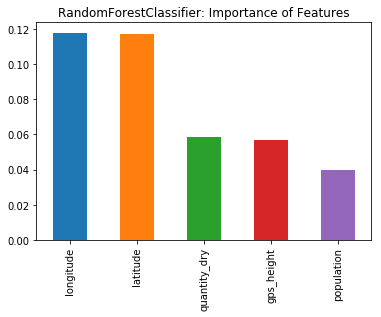

In [444]:
wp_models._cross_validate(wp_data, k_fold=3)